In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np                  
import matplotlib.pyplot as plt                    # plots
%matplotlib inline
from datetime import datetime, timedelta
from scipy import stats
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
np.random.seed(1)

In [2]:
data = pd.read_excel(r'C:\Users\u22v09\Desktop\Billing Data 2016 to July 2020.xlsx',skiprows=3)

In [3]:
# data[['Customer Segment']].bfill(axis = 0) 
data['Customer Segment ']= data['Customer Segment '].fillna(method = "ffill")

In [4]:
data.drop('Grand Total', axis = 1, inplace = True)
data=pd.melt(data, id_vars =['Month','Customer Segment '])
data=data.dropna()


In [5]:
df=data.copy()
df['Date'] =pd.to_datetime(df.variable.astype(str) + '/' + df.Month.astype(str) + '/01')



In [6]:
df = df.sort_values('Date')
df = df.set_index('Date')
df=df.rename(columns={'value':'ASP','variable':'Year'})

In [7]:
df.head()

,Month,Customer Segment,Year,ASP
Date,,,,
2016-01-01,Jan,DIR,2016,80.867485
2016-01-01,Jan,OEM,2016,0.000000
2016-01-01,Jan,Networking,2016,10.367355
2016-01-01,Jan,Govt.,2016,0.000000
2016-01-01,Jan,Service,2016,39.269113


In [8]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [47]:
df_dir =  df[df['Customer Segment '] == 'Service']
# df_dir = pd.DataFrame(df_dir.groupby(['Year', 'Month'])['ASP'].sum()).reset_index()
# df_dir['Date'] = pd.to_datetime(df_dir.Year.astype(str) + '/' + df_dir.Month.astype(str) + '/01')
# df_dir = df_dir.sort_values('Date')
# df_dir = df_dir.set_index('Date')
df_dir = df_dir_plot =  df_dir[['ASP']]
df_dir.index.freq = 'MS'

raw_seq = list(df_dir['ASP'].values)
n_steps = 9
df_dir_X, df_dir_y = split_sequence(raw_seq, n_steps = n_steps)
t =[]
x =[]
for i in range(len(df_dir_X)):
    t.append(df_dir_X[i])
    x.append(df_dir_y[i])
inp = pd.DataFrame(t)
# inp = inp.rename(columns= {0:'in'})
out = pd.DataFrame(x)
out = out.rename(columns= {0:9})
df_dir = inp.merge(out, left_index = True, right_index = True)
df_dir.tail()

,0,1,2,3,4,5,6,7,8,9
41,57.534152,77.380758,56.547062,65.652423,61.446451,97.236324,69.605557,40.338784,57.894122,44.468303
42,77.380758,56.547062,65.652423,61.446451,97.236324,69.605557,40.338784,57.894122,44.468303,0.000000
43,56.547062,65.652423,61.446451,97.236324,69.605557,40.338784,57.894122,44.468303,0.000000,6.430842
44,65.652423,61.446451,97.236324,69.605557,40.338784,57.894122,44.468303,0.000000,6.430842,48.785316
45,61.446451,97.236324,69.605557,40.338784,57.894122,44.468303,0.000000,6.430842,48.785316,65.772139


In [48]:
x_in = df_dir[-1:][range(5,10)]
x_in

,5,6,7,8,9
45,44.468303,0.0,6.430842,48.785316,65.772139


In [49]:
df_dir_X = df_dir[range(0,5)]
df_dir_X = np.atleast_2d(df_dir_X.values)
len(df_dir_X)

46

In [50]:
df_dir_X.shape

(46, 5)

In [51]:
df_dir_y = df_dir[range(5,10)]
df_dir_y = np.atleast_2d(df_dir_y.values)
len(df_dir_y)

46

In [52]:
df_dir_train_X = df_dir_X
df_dir_train_y = df_dir_y

In [53]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=0).fit(df_dir_train_X, df_dir_train_y)

pred_rmse = gp.predict((np.atleast_2d(df_dir_train_X[-1])))
pred_rmse = pd.DataFrame(list(pred_rmse[0]), columns = ['Prediction'], index = pd.date_range(start = '2020-08-01', periods=5, freq='MS'))
pred_rmse['test'] = list(df_dir_train_y[-1])
print(pred_rmse)
rms = sqrt(mean_squared_error(pred_rmse['test'], pred_rmse['Prediction']))
print(round(rms,2))


pred , sigma = gp.predict(x_in ,return_std=True)
pred = pd.DataFrame(list(pred[0]), columns = ['Prediction'], index = pd.date_range(start = '2020-08-01', periods=5, freq='MS'))
#print(pred.round(2))
pred['lower_95']=pred['Prediction'].round(2) - 1.9600 * sigma
pred['upper_95']=pred['Prediction'].round(2) + 1.9600 * sigma
pred['lower_80']=pred['Prediction'].round(2) - 1.282 * sigma
pred['upper_80']=pred['Prediction'].round(2) + 1.282 * sigma

            Prediction       test
2020-08-01   57.769594  44.468303
2020-09-01   48.339394   0.000000
2020-10-01   51.236971   6.430842
2020-11-01   51.259298  48.785316
2020-12-01   49.056596  65.772139
31.01


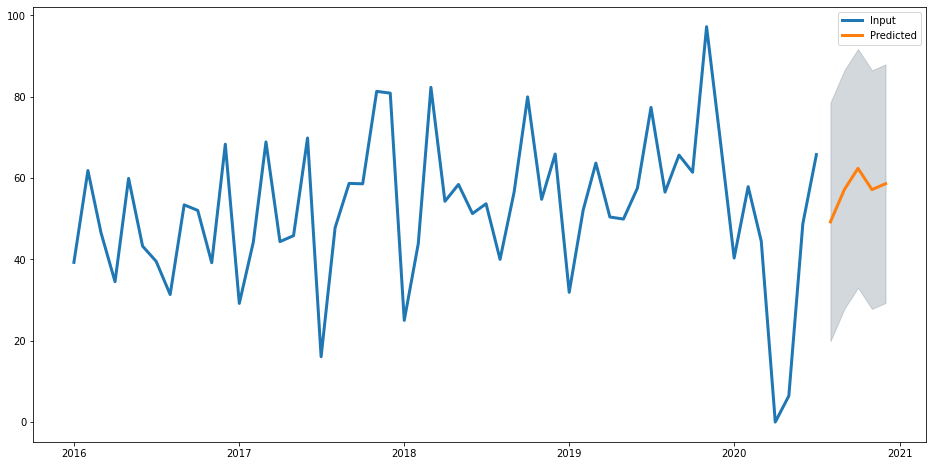

In [54]:
plt.figure(figsize=(16,8))
plt.plot(df_dir_plot['ASP'], label = "Input", lw = 3)
plt.plot(pred['Prediction'], label='Predicted', lw = 3)
plt.fill_between(pred.index,pred.lower_80, pred.upper_80,alpha=0.3,color='slategrey')
plt.legend(loc='best')
plt.show()

In [55]:
pred['Prediction']

2020-08-01    49.224851
2020-09-01    57.190180
2020-10-01    62.392610
2020-11-01    57.154975
2020-12-01    58.626446
Freq: MS, Name: Prediction, dtype: float64

In [56]:
pred['lower_95']

2020-08-01     4.368397
2020-09-01    12.338397
2020-10-01    17.538397
2020-11-01    12.298397
2020-12-01    13.778397
Freq: MS, Name: lower_95, dtype: float64

In [57]:
pred['upper_80']

2020-08-01    78.55661
2020-09-01    86.52661
2020-10-01    91.72661
2020-11-01    86.48661
2020-12-01    87.96661
Freq: MS, Name: upper_80, dtype: float64